## Heteroscedastic uncertainty

### Example of learning the aleatoric heteroscedastic uncertainty by learning a simple linear regression

In [1]:
#!pip install keras==2.0.8
from keras.callbacks import TensorBoard
from keras.layers import Input, Dense, concatenate, Flatten
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop, Nadam
from keras.initializers import RandomNormal
from keras.layers import multiply, add
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


First we create some samples from 0 to 40 and add some noise. In this case we have two variables with the same noise distribution, x and z, that we'll use to show that gimas can be calculated using two variables as inputs.

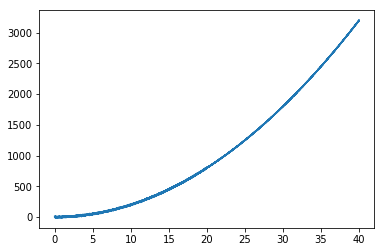

In [2]:
x = np.linspace(0, 20, 10000)#, dtype="int32")  # 100000 values between 0 and 100
deltax = np.random.normal(0, 4, x.size)
z = np.linspace(0, 20, 10000)
deltaz = np.random.normal(0, 3, z.size)
y = 2 * x * z + deltax + deltaz
x2 = np.linspace(20, 40, 10000)
deltax2 = np.random.normal(0, 1, x2.size)
z2 = np.linspace(20, 40, 10000)
deltaz2 = np.random.normal(0, 2, x2.size)
y2 = 2*x2*z2 + deltax2 + deltaz2
x = np.append(x, x2)
z = np.append(z, z2)
y = np.append(y, y2)
plt.plot(x,y)
plt.show()

Epoch 1/200
20000/20000 [==============================] - 0s - loss: 2554088.4152 - mean_squared_error: 2554088.4152     
Epoch 2/200
20000/20000 [==============================] - 0s - loss: 2448768.0904 - mean_squared_error: 2448768.0904     
Epoch 3/200
20000/20000 [==============================] - 0s - loss: 2346943.9440 - mean_squared_error: 2346943.9440     
Epoch 4/200
20000/20000 [==============================] - 0s - loss: 2248461.5456 - mean_squared_error: 2248461.5456     
Epoch 5/200
20000/20000 [==============================] - 0s - loss: 2152744.9488 - mean_squared_error: 2152744.9488     
Epoch 6/200
20000/20000 [==============================] - 0s - loss: 2059937.9872 - mean_squared_error: 2059937.9872     
Epoch 7/200
20000/20000 [==============================] - 0s - loss: 1970099.7732 - mean_squared_error: 1970099.7732     
Epoch 8/200
20000/20000 [==============================] - 0s - loss: 1882772.9266 - mean_squared_error: 1882772.9266     
Epoch 9/200
2000

20000/20000 [==============================] - 0s - loss: 369.8047 - mean_squared_error: 369.8047     
Epoch 69/200
20000/20000 [==============================] - 0s - loss: 223.5907 - mean_squared_error: 223.5907     
Epoch 70/200
20000/20000 [==============================] - 0s - loss: 133.0974 - mean_squared_error: 133.0974     
Epoch 71/200
20000/20000 [==============================] - 0s - loss: 79.3488 - mean_squared_error: 79.3488     
Epoch 72/200
20000/20000 [==============================] - 0s - loss: 48.8936 - mean_squared_error: 48.8936     
Epoch 73/200
20000/20000 [==============================] - 0s - loss: 32.5843 - mean_squared_error: 32.5843     
Epoch 74/200
20000/20000 [==============================] - 0s - loss: 24.3313 - mean_squared_error: 24.3313     
Epoch 75/200
20000/20000 [==============================] - 0s - loss: 20.4301 - mean_squared_error: 20.4301     
Epoch 76/200
20000/20000 [==============================] - 0s - loss: 18.6958 - mean_squared_e

20000/20000 [==============================] - 0s - loss: 16.1106 - mean_squared_error: 16.1106     
Epoch 140/200
20000/20000 [==============================] - 0s - loss: 16.0693 - mean_squared_error: 16.0693     
Epoch 141/200
20000/20000 [==============================] - 0s - loss: 16.0355 - mean_squared_error: 16.0355     
Epoch 142/200
20000/20000 [==============================] - 0s - loss: 15.9892 - mean_squared_error: 15.9892     
Epoch 143/200
20000/20000 [==============================] - 0s - loss: 15.9431 - mean_squared_error: 15.9431     
Epoch 144/200
20000/20000 [==============================] - 0s - loss: 15.9204 - mean_squared_error: 15.9204     
Epoch 145/200
20000/20000 [==============================] - 0s - loss: 15.8791 - mean_squared_error: 15.8791     
Epoch 146/200
20000/20000 [==============================] - 0s - loss: 15.8397 - mean_squared_error: 15.8397     
Epoch 147/200
20000/20000 [==============================] - 0s - loss: 15.8029 - mean_squared

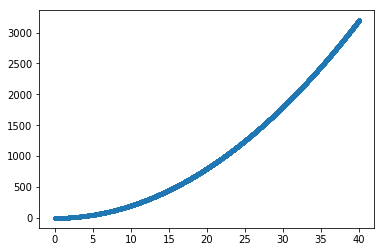

In [3]:
raw_input1 = Input(shape=(1,))
raw_input2 = Input(shape=(1,))
product = multiply([raw_input1,raw_input2])
raw_preds = Dense(1, activation='linear', name="preds")(product)

rawmodel = Model(inputs=[raw_input1,raw_input2],outputs=raw_preds)
adam = Adam(lr=0.0003)
rawmodel.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
rawmodel.fit([x, z], y, batch_size=128, epochs=200, shuffle=True)
raw_result = rawmodel.predict([x, z])
plt.plot(x, raw_result[:,0],'.')
plt.show()

In [4]:
rawmodel.layers[3].get_weights()

[array([[ 1.99987495]], dtype=float32), array([ 0.03924593], dtype=float32)]

These are the function used to include the calculation of the sigmas in the loss.
Note that we use the trick of concatenating the sigma to the ouput, so the prediction is at index 0 and the sigma is at index 1 of the resulting output. Note that differently from the 1 input version, in this case the sigma is not squared. This is because the sigma here applied is the combination of the sigmas of the 2 inputs, each of them squared in the model

In [5]:
def aleatoric_loss(y_true, y_pred):
    sigma = y_pred[:, 1]
    epsilon = 1e-6
    y_pred_prima = y_pred[:, 0]
    output_value = ((K.square(y_pred_prima - y_true[:, 0])) / (K.square(sigma)+ epsilon)) + K.log(K.square(sigma) + epsilon)
    return K.mean(output_value, axis=-1)

def aleatoric_rms(y_true, y_pred):
    y_pred_prima = y_pred[:, 0]
    return K.mean(K.square(y_pred_prima - y_true[:, 0]), axis=-1)

First we try a model without calculating the sigma and plot some results.

Then we try a model where the sigmas are computed. In this case we have two sigmas, on for each input, that share the same network. Sigmas are squared and combined, by adding them, as a resulting sigma that is train in the loss together with the mean squared error of the labels and the predictions.

In [6]:
input1 = Input(shape=(1,))
input2 = Input(shape=(1,))
inputs = concatenate([input1,input2])
sigma_hidden1 = Dense(15, activation='relu', name="sigma", kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None))(inputs)
sigma_hidden2 = Dense(10, activation='relu', name="sigma2", kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None))(sigma_hidden1)
sigma = Dense(1, activation='linear', name="sigma_output", kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None))(sigma_hidden2)
product = multiply([input1,input2])
preds = Dense(1, activation='linear', name="preds")(product)
aleatoric_output = concatenate([preds, sigma])
model = Model(inputs=[input1,input2],outputs=aleatoric_output)
model.compile(optimizer=Adam(lr=0.0003), loss=aleatoric_loss, metrics=[aleatoric_rms])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
concatenate_1 (Concatenate)      (None, 2)             0           input_3[0][0]                    
                                                                   input_4[0][0]                    
____________________________________________________________________________________________________
sigma (Dense)                    (None, 15)            45          concatenate_1[0][0]     

In [7]:
model.fit([x, z], np.expand_dims(y, axis=1).repeat(2, axis=1), batch_size=64, epochs=450, shuffle=False)

Epoch 1/450
20000/20000 [==============================] - 0s - loss: 9517960.9208 - aleatoric_rms: 2538184.6271     
Epoch 2/450
20000/20000 [==============================] - 0s - loss: 1373514.0977 - aleatoric_rms: 2481661.5648     
Epoch 3/450
20000/20000 [==============================] - 0s - loss: 779103.9203 - aleatoric_rms: 2444734.9704     
Epoch 4/450
20000/20000 [==============================] - 0s - loss: 524093.9673 - aleatoric_rms: 2414435.3201     
Epoch 5/450
20000/20000 [==============================] - 0s - loss: 383195.0053 - aleatoric_rms: 2387725.6830     
Epoch 6/450
20000/20000 [==============================] - 0s - loss: 294454.7063 - aleatoric_rms: 2363230.1639     
Epoch 7/450
20000/20000 [==============================] - 0s - loss: 233823.2046 - aleatoric_rms: 2340181.7303     
Epoch 8/450
20000/20000 [==============================] - 0s - loss: 190024.2133 - aleatoric_rms: 2318098.3096     
Epoch 9/450
20000/20000 [==============================] - 0s 

20000/20000 [==============================] - 0s - loss: 18.4196 - aleatoric_rms: 1188208.9528    
Epoch 72/450
20000/20000 [==============================] - 0s - loss: 17.7692 - aleatoric_rms: 1173368.2758    
Epoch 73/450
20000/20000 [==============================] - 0s - loss: 17.1876 - aleatoric_rms: 1157666.6344     
Epoch 74/450
20000/20000 [==============================] - 0s - loss: 16.6679 - aleatoric_rms: 1141055.2593    
Epoch 75/450
20000/20000 [==============================] - 0s - loss: 16.2038 - aleatoric_rms: 1123485.8161    
Epoch 76/450
20000/20000 [==============================] - 0s - loss: 15.7897 - aleatoric_rms: 1104909.0995    A: 0s - loss: 8.4721 - aleatoric_rms
Epoch 77/450
20000/20000 [==============================] - 0s - loss: 15.4205 - aleatoric_rms: 1085272.8362    
Epoch 78/450
20000/20000 [==============================] - 0s - loss: 15.0917 - aleatoric_rms: 1064526.6651    
Epoch 79/450
20000/20000 [==============================] - 0s - loss: 1

20000/20000 [==============================] - 0s - loss: 3.4498 - aleatoric_rms: 15.2140     
Epoch 145/450
20000/20000 [==============================] - 0s - loss: 3.4501 - aleatoric_rms: 15.2133     
Epoch 146/450
20000/20000 [==============================] - 0s - loss: 3.4503 - aleatoric_rms: 15.2126     
Epoch 147/450
20000/20000 [==============================] - 0s - loss: 3.4505 - aleatoric_rms: 15.2120     
Epoch 148/450
20000/20000 [==============================] - 0s - loss: 3.4507 - aleatoric_rms: 15.2114     
Epoch 149/450
20000/20000 [==============================] - 0s - loss: 3.4509 - aleatoric_rms: 15.2108     
Epoch 150/450
20000/20000 [==============================] - 0s - loss: 3.4510 - aleatoric_rms: 15.2102     
Epoch 151/450
20000/20000 [==============================] - 0s - loss: 3.4512 - aleatoric_rms: 15.2097     
Epoch 152/450
20000/20000 [==============================] - 0s - loss: 3.4513 - aleatoric_rms: 15.2092     
Epoch 153/450
20000/20000 [======

20000/20000 [==============================] - 0s - loss: 3.4564 - aleatoric_rms: 15.1989     
Epoch 219/450
20000/20000 [==============================] - 0s - loss: 3.4563 - aleatoric_rms: 15.1990     
Epoch 220/450
20000/20000 [==============================] - 0s - loss: 3.4564 - aleatoric_rms: 15.1989     
Epoch 221/450
20000/20000 [==============================] - 0s - loss: 3.4563 - aleatoric_rms: 15.1989     
Epoch 222/450
20000/20000 [==============================] - 0s - loss: 3.4564 - aleatoric_rms: 15.1989     
Epoch 223/450
20000/20000 [==============================] - 0s - loss: 3.4564 - aleatoric_rms: 15.1989     
Epoch 224/450
20000/20000 [==============================] - 0s - loss: 3.4564 - aleatoric_rms: 15.1989     
Epoch 225/450
20000/20000 [==============================] - 0s - loss: 3.4563 - aleatoric_rms: 15.1989     
Epoch 226/450
20000/20000 [==============================] - 0s - loss: 3.4563 - aleatoric_rms: 15.1989     
Epoch 227/450
20000/20000 [======

20000/20000 [==============================] - 0s - loss: 3.4601 - aleatoric_rms: 15.1990     
Epoch 294/450
20000/20000 [==============================] - 0s - loss: 3.4600 - aleatoric_rms: 15.1989     
Epoch 295/450
20000/20000 [==============================] - 0s - loss: 3.4599 - aleatoric_rms: 15.1990     
Epoch 296/450
20000/20000 [==============================] - 0s - loss: 3.4598 - aleatoric_rms: 15.1990     
Epoch 297/450
20000/20000 [==============================] - 0s - loss: 3.4597 - aleatoric_rms: 15.1990     
Epoch 298/450
20000/20000 [==============================] - 0s - loss: 3.4596 - aleatoric_rms: 15.1990     
Epoch 299/450
20000/20000 [==============================] - 0s - loss: 3.4595 - aleatoric_rms: 15.1990     
Epoch 300/450
20000/20000 [==============================] - 0s - loss: 3.4593 - aleatoric_rms: 15.1990     
Epoch 301/450
20000/20000 [==============================] - 0s - loss: 3.4586 - aleatoric_rms: 15.1990     
Epoch 302/450
20000/20000 [======

20000/20000 [==============================] - 0s - loss: 3.4401 - aleatoric_rms: 15.1990     
Epoch 369/450
20000/20000 [==============================] - 0s - loss: 3.4400 - aleatoric_rms: 15.1990     
Epoch 370/450
20000/20000 [==============================] - 0s - loss: 3.4393 - aleatoric_rms: 15.1990     
Epoch 371/450
20000/20000 [==============================] - 0s - loss: 3.4391 - aleatoric_rms: 15.1990     
Epoch 372/450
20000/20000 [==============================] - 0s - loss: 3.4389 - aleatoric_rms: 15.1990     
Epoch 373/450
20000/20000 [==============================] - 0s - loss: 3.4387 - aleatoric_rms: 15.1990     
Epoch 374/450
20000/20000 [==============================] - 0s - loss: 3.4391 - aleatoric_rms: 15.1990     
Epoch 375/450
20000/20000 [==============================] - 0s - loss: 3.4394 - aleatoric_rms: 15.1990     
Epoch 376/450
20000/20000 [==============================] - 0s - loss: 3.4391 - aleatoric_rms: 15.1990     
Epoch 377/450
20000/20000 [======

20000/20000 [==============================] - 0s - loss: 3.4368 - aleatoric_rms: 15.1990     
Epoch 444/450
20000/20000 [==============================] - 0s - loss: 3.4364 - aleatoric_rms: 15.1989     
Epoch 445/450
20000/20000 [==============================] - 1s - loss: 3.4359 - aleatoric_rms: 15.1989     
Epoch 446/450
20000/20000 [==============================] - 0s - loss: 3.4369 - aleatoric_rms: 15.1991     
Epoch 447/450
20000/20000 [==============================] - 0s - loss: 3.4362 - aleatoric_rms: 15.1989     
Epoch 448/450
20000/20000 [==============================] - 0s - loss: 3.4364 - aleatoric_rms: 15.1990     
Epoch 449/450
20000/20000 [==============================] - 0s - loss: 3.4366 - aleatoric_rms: 15.1990     
Epoch 450/450
20000/20000 [==============================] - 0s - loss: 3.4359 - aleatoric_rms: 15.1989     


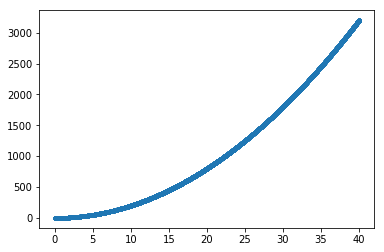

In [8]:
result = model.predict([x,z])
plt.plot(x, result[:,0],'.')
plt.show()

Here we plot the two sigmas. As we can see, the sigma for the first variable though for the second one the predicted sigma is quite wrong.

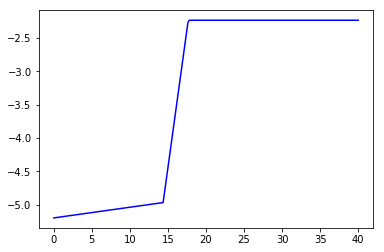

In [9]:
model_sigmas_x = Model(inputs=[input1,input2], outputs=sigma)
sigmas = model_sigmas_x.predict([x,z])
real_sigmas = np.sqrt(np.square(deltax) + np.square(deltaz))
plt.plot(x, sigmas[:,0], 'b-')
plt.show()

In [10]:
model.layers[6].get_weights()

[array([[ 2.00039101]], dtype=float32), array([-0.12078033], dtype=float32)]

In [12]:
(4**2+3**2)**0.5

5.0

In [13]:
(1**2+2**2)**0.5

2.23606797749979